In [56]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt



In [57]:
ts = pd.read_csv('./point_timeseries/ts_point_0202_all.csv',parse_dates=True,index_col=0)
ts

,0
1901-01-01,7.45
1901-02-01,7.11
1901-03-01,7.07
1901-04-01,7.33
1901-05-01,8.00
...,...
2019-08-01,12.27
2019-09-01,11.01
2019-10-01,10.10
2019-11-01,8.81


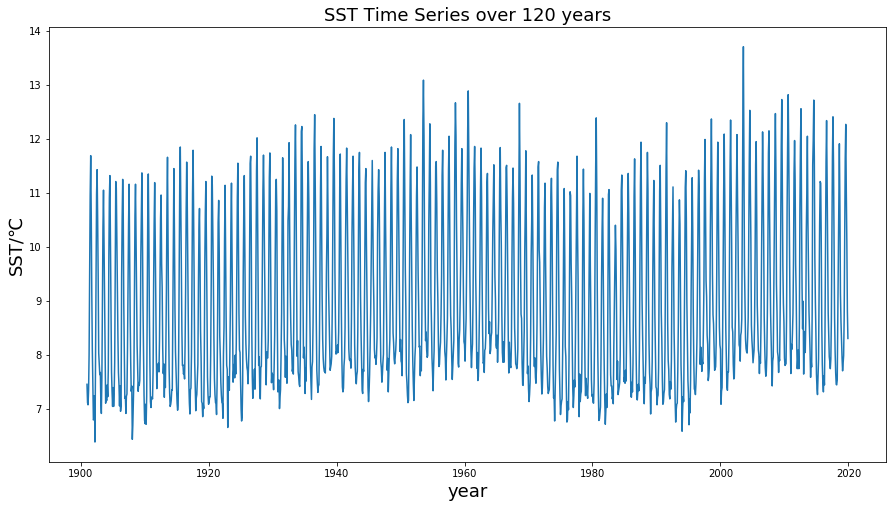

In [111]:
#ts.plot()
plt.figure(figsize=(15,8))
plt.plot(ts['0'])
plt.xlabel('year',fontsize=18)
plt.ylabel('SST/℃',fontsize=18)
plt.title('SST Time Series over 120 years',fontsize=18)
plt.show()

# Difference

In [60]:
ts['diff_1'] = ts['0'].diff(1)
ts['diff_2'] = ts['0'].diff(2)
ts

,0,diff_1,diff_2
1901-01-01,7.45,NaN,NaN
1901-02-01,7.11,-0.34,NaN
1901-03-01,7.07,-0.04,-0.38
1901-04-01,7.33,0.26,0.22
1901-05-01,8.00,0.67,0.93
...,...,...,...
2019-08-01,12.27,0.63,2.17
2019-09-01,11.01,-1.26,-0.63
2019-10-01,10.10,-0.91,-2.17
2019-11-01,8.81,-1.29,-2.20


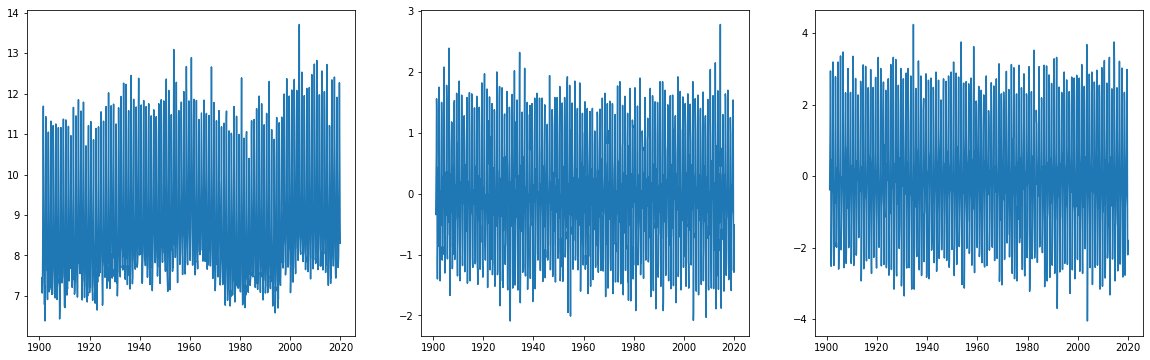

In [61]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
ax1.plot(ts['0'])
ax2 = fig.add_subplot(132)
ax2.plot(ts['diff_1'])
ax3 = fig.add_subplot(133)
ax3.plot(ts['diff_2'])
plt.show()

# Test Stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    
    rolmean = timeseries.rolling(window=12).mean()
    #pd.rolling_mean(timeseries, window=12)
    
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

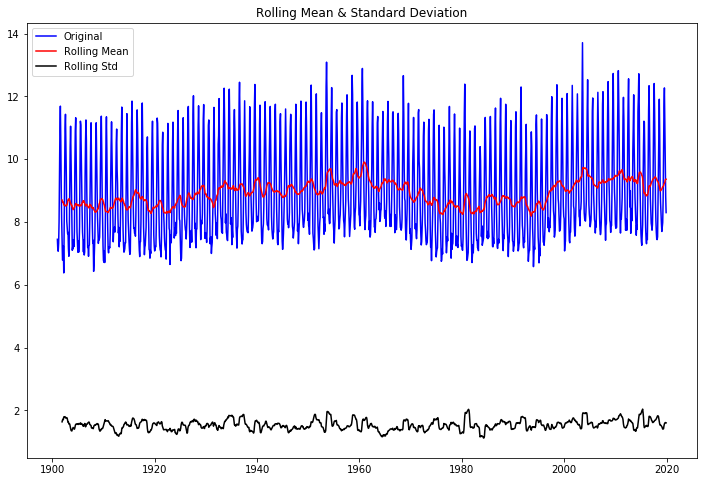

Results of Dickey-Fuller Test:
Test Statistic                   -2.625928
p-value                           0.087756
#Lags Used                       24.000000
Number of Observations Used    1403.000000
Critical Value (1%)              -3.435019
Critical Value (5%)              -2.863602
Critical Value (10%)             -2.567868
dtype: float64


In [62]:
test_stationarity(ts['0'].dropna(inplace=False))

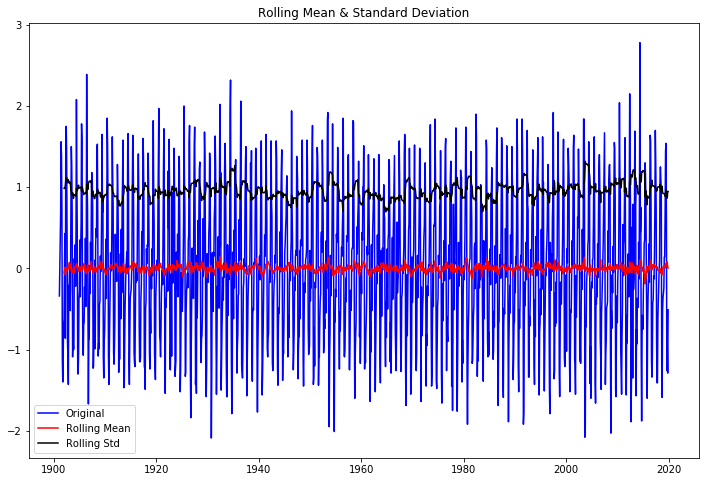

Results of Dickey-Fuller Test:
Test Statistic                -1.166235e+01
p-value                        1.919897e-21
#Lags Used                     2.400000e+01
Number of Observations Used    1.402000e+03
Critical Value (1%)           -3.435023e+00
Critical Value (5%)           -2.863604e+00
Critical Value (10%)          -2.567869e+00
dtype: float64


In [63]:
test_stationarity(ts['diff_1'].dropna(inplace=False))

# Draw Autocorrelation & Partial Autocorrelatio

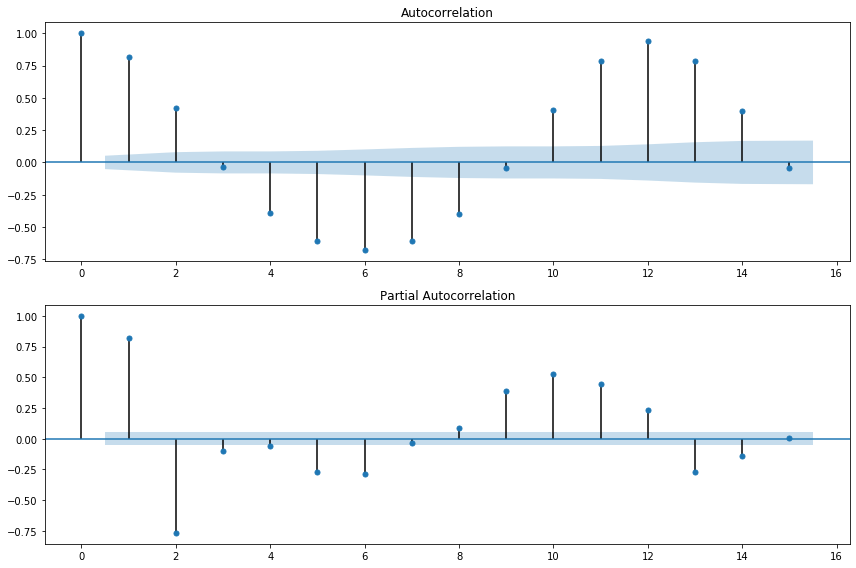

In [64]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['0'], lags=15,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['0'], lags=15, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()


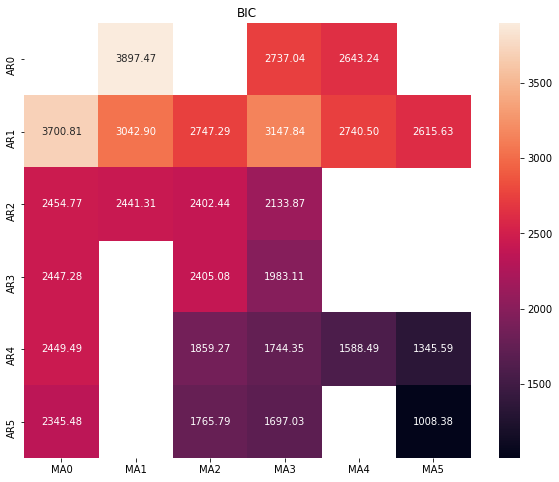

In [112]:
#遍历，寻找适宜的参数
import itertools
import numpy as np
import seaborn as sns
 
p_min = 0
d_min = 0
q_min = 0
p_max = 5
d_max = 0
q_max = 5
 
# Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(ts['0'], order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')
plt.show()

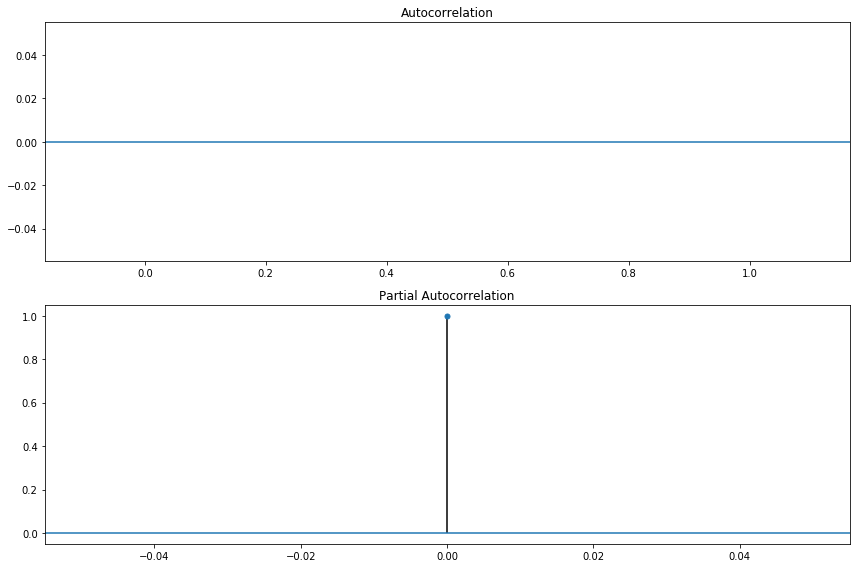

In [88]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['diff_1'], lags=15,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['diff_1'], lags=15, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()


In [89]:
import warnings
warnings.filterwarnings("ignore")

train_results = sm.tsa.arma_order_select_ic(ts['0'], ic=['aic', 'bic'], trend='nc', max_ar=5, max_ma=5)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)



AIC (5, 3)
BIC (5, 3)


# ARIMA(5, 0, 3)

In [115]:
model = sm.tsa.ARIMA(ts['0'], order=(5, 0, 3))
results = model.fit()

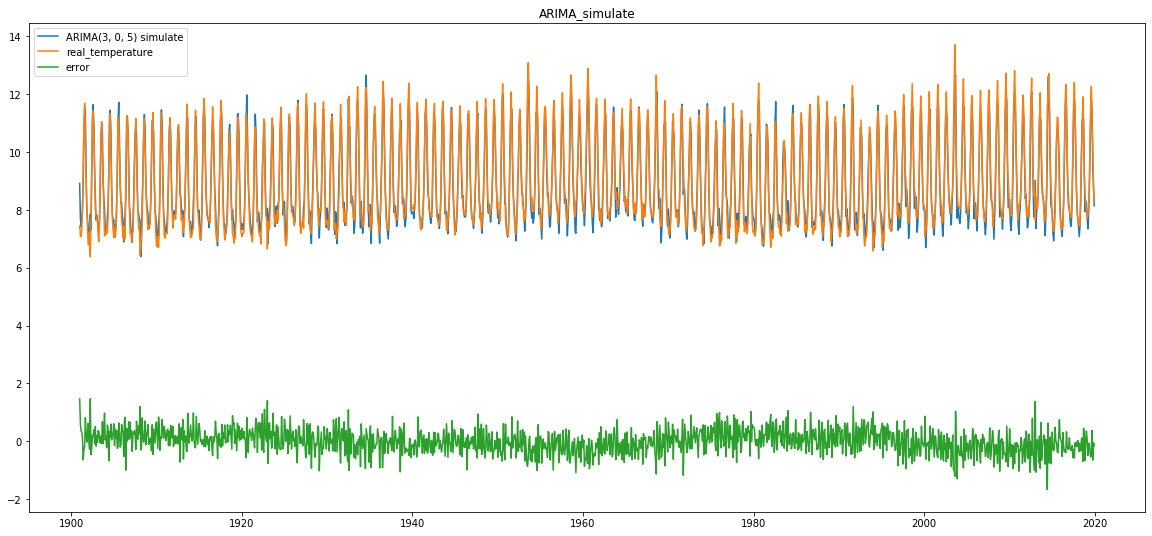

In [127]:
predict_sunspots = results.fittedvalues
plt.figure(figsize=(20, 9))
plt.plot(predict_sunspots, label='ARIMA(3, 0, 5) simulate')
plt.plot(ts['0'], label='real_temperature')
error_ts = predict_sunspots-ts['0']
plt.plot(error_ts, label='error')
plt.title("ARIMA_simulate")
plt.legend(loc='best')
plt.show()

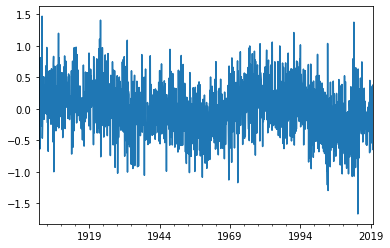

In [98]:
error_ts.plot()

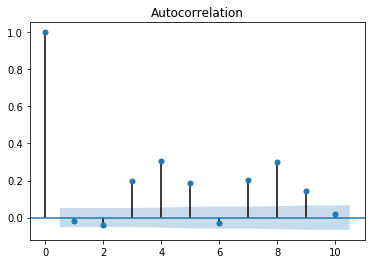

<Figure size 1080x576 with 0 Axes>

In [121]:
results = model.fit()
resid = results.resid #赋值

fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=10, )
plt.figure(figsize=(15,8))
plt.show()


In [118]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      0   No. Observations:                 1428
Model:                     ARMA(5, 3)   Log Likelihood                -812.197
Method:                       css-mle   S.D. of innovations              0.426
Date:                Tue, 18 Feb 2020   AIC                           1644.393
Time:                        01:09:28   BIC                           1697.033
Sample:                    01-01-1901   HQIC                          1664.052
                         - 12-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9167      0.022    404.011      0.000       8.873       8.960
ar.L1.0        2.4088      0.028     84.614      0.000       2.353       2.465
ar.L2.0       -2.8665      0.075    -38.411      0.0

In [79]:
month_data = ts[::12]
month_data

,0,diff_1,diff_2
1901-01-01,7.45,NaN,NaN
1902-01-01,6.79,-0.62,-1.31
1903-01-01,7.63,-0.19,-0.40
1904-01-01,7.22,0.12,-0.87
1905-01-01,7.04,-0.28,-0.64
...,...,...,...
2015-01-01,7.64,-0.75,-1.33
2016-01-01,7.47,-0.35,-1.06
2017-01-01,7.96,-0.38,-0.81
2018-01-01,7.67,-0.39,-1.02


In [84]:
ts[3::12]

,0,diff_1,diff_2
1901-04-01,7.33,0.26,0.22
1902-04-01,6.38,-0.86,-0.43
1903-04-01,6.91,-0.24,-0.76
1904-04-01,7.22,-0.22,0.07
1905-04-01,7.27,0.23,-0.12
...,...,...,...
2015-04-01,7.57,0.31,0.20
2016-04-01,7.44,-0.17,0.13
2017-04-01,7.92,0.18,0.05
2018-04-01,7.53,0.09,0.08


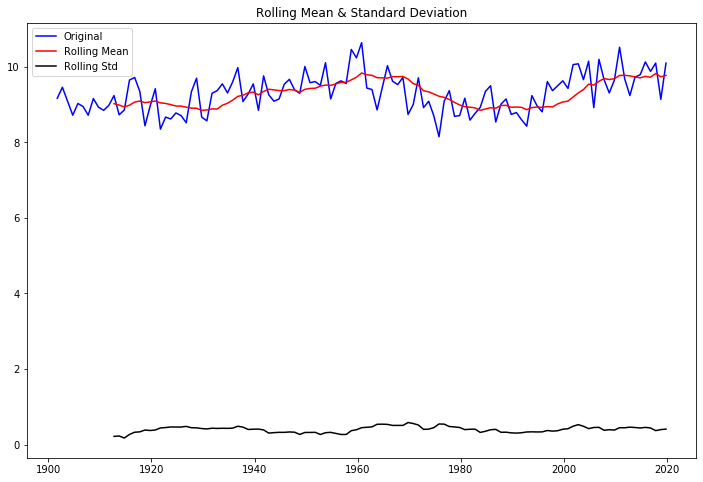

Results of Dickey-Fuller Test:
Test Statistic                  -2.992829
p-value                          0.035569
#Lags Used                       2.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


In [87]:
test_stationarity(ts[9::12]['0'].dropna(inplace=False))